## `Data Preparation`

In [32]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt

# Machine Learning Packages:
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from sklearn.metrics import accuracy_score


In [2]:
train_df = pd.read_csv('Data/train.csv')

In [3]:
train_df.head(2)

,Unnamed: 0,customerid,gender,seniorcitizen,partner,dependents,tenure,phoneservice,multiplelines,internetservice,...,deviceprotection,techsupport,streamingtv,streamingmovies,contract,paperlessbilling,paymentmethod,monthlycharges,totalcharges,churn
0,0,7590-VHVEG,Female,0,Yes,No,1,No,NaN,DSL,...,No,No,No,No,Month-to-month,Yes,Electronic check,29.850000,29.85,No
1,1,5575-GNVDE,Male,0,No,No,34,Yes,No,DSL,...,Yes,No,No,No,One year,No,Mailed check,56.950001,1889.50,No


In [4]:
train_df.drop(columns=['customerid','Unnamed: 0'], axis = 1, inplace = True)

In [5]:
train_df.head(2)

,gender,seniorcitizen,partner,dependents,tenure,phoneservice,multiplelines,internetservice,onlinesecurity,onlinebackup,deviceprotection,techsupport,streamingtv,streamingmovies,contract,paperlessbilling,paymentmethod,monthlycharges,totalcharges,churn
0,Female,0,Yes,No,1,No,NaN,DSL,No,Yes,No,No,No,No,Month-to-month,Yes,Electronic check,29.850000,29.85,No
1,Male,0,No,No,34,Yes,No,DSL,Yes,No,Yes,No,No,No,One year,No,Mailed check,56.950001,1889.50,No


In [6]:
train_df.isna().sum()

gender                0
seniorcitizen         0
partner               0
dependents            0
tenure                0
phoneservice          0
multiplelines       269
internetservice       0
onlinesecurity      651
onlinebackup        651
deviceprotection    651
techsupport         651
streamingtv         651
streamingmovies     651
contract              0
paperlessbilling      0
paymentmethod         0
monthlycharges        0
totalcharges          8
churn                 1
dtype: int64

#### To prevent data leakage, drop row with missing value in the churn column

In [7]:
train_df.dropna(subset='churn', inplace=True)

Check if the target variable is balanced

In [8]:
churn_distribution = train_df['churn'].value_counts().rename('total').reset_index()
churn_distribution

,churn,total
0,No,3706
1,Yes,1336


Splitting the data into X and y variables

In [9]:
X = train_df.drop('churn', axis =1)
y = train_df[['churn']]




In [10]:
# DATA LEAKAGE ISSUES??? Do imputations only after train_test_split and only on y_train
# y_imputer = SimpleImputer(strategy='most_frequent', missing_values= pd.NA)
 
# y_imputed = y_imputer.fit_transform(y)
 
# y_imputed = pd.DataFrame(y_imputed, columns=y.columns)

In [11]:

# X_train_, X_eval_, y_train, y_eval =  train_test_split(X, y_imputed, test_size=0.2, random_state=42, stratify=y_imputed)

In [12]:
X_train, X_eval, y_train, y_eval =  train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

In [13]:
encoder = LabelEncoder()

y_train_encoded = encoder.fit_transform(y_train['churn'])
y_eval_encoded = encoder.transform(y_eval['churn'])


### Preparing Pipelines

In [14]:
numerical_columns = X.select_dtypes('number').columns
categorical_columns = X.select_dtypes('object').columns

In [15]:
numerical_pipeline = Pipeline(steps=[
    ('num_imputer', SimpleImputer(strategy = 'median')),
    ('num_scaler', StandardScaler())
])

categorical_pipeline = Pipeline(steps=[
    ('cat_imputer', SimpleImputer(strategy='most_frequent')),
    ('cat-encoder', OneHotEncoder(handle_unknown='ignore'))
])

preprocessor = ColumnTransformer(transformers=[
    ('num', numerical_pipeline, numerical_columns),
    ('cat', categorical_pipeline, categorical_columns)
])

### Modelling

In [16]:
models =[
    ('Decision_tree', DecisionTreeClassifier(random_state=42)),
    ('Logistic_reg', LogisticRegression(random_state=42)),
    ('knn', KNeighborsClassifier(n_neighbors=5)),
    ('random_forest', RandomForestClassifier(random_state = 42))
]

# Creating dictionary for the models
all_pipelines = {}

# Create an empty DataFrame for metrics
metrics_table = pd.DataFrame(columns=['model_name', 'accuracy', 'precision', 'recall', 'f1_score'])

# Loop over models and create pipelines, fit models, and calculate metrics
for model_name, classifier in models:
    final_pipeline = Pipeline(steps=[
        ('preprocessor', preprocessor),
        ('classifier', classifier)
    ])
    
    # Fit the pipeline on training data
    final_pipeline.fit(X_train, y_train_encoded)
    
    # Make predictions on the evaluation dataset
    y_pred = final_pipeline.predict(X_eval)
    
    # Calculate classification report metrics
    metrics = classification_report(y_eval_encoded, y_pred, output_dict=True)
    
    # Extract metrics for the current model
    accuracy = metrics['accuracy']
    precision = metrics['weighted avg']['precision']
    recall = metrics['weighted avg']['recall']
    f1_score = metrics['weighted avg']['f1-score']
    
    # Add metrics to metrics_table
    metrics_table.loc[len(metrics_table)] = [model_name, accuracy, precision, recall, f1_score]

# Display the metrics table
metrics_table.sort_values(ascending=False, by='f1_score')

,model_name,accuracy,precision,recall,f1_score
1,Logistic_reg,0.799802,0.794989,0.799802,0.796963
3,random_forest,0.786918,0.776866,0.786918,0.779906
2,knn,0.765114,0.764275,0.765114,0.764687
0,Decision_tree,0.723489,0.731998,0.723489,0.727303


### Hyperparameter Tuning

In [17]:
# Define the hyperparameters to search

param_grids = {

    'Decision_tree': {
        'classifier__max_depth': [None, 10, 20, 30],
        'classifier__min_samples_split': [2, 5, 10]
    },

    'Logistic_reg': {
        'classifier__C': [0.001, 0.01, 0.1, 1, 10, 100],        
        'classifier__solver' : ['lbfgs', 'liblinear', 'newton-cg', 'newton-cholesky', 'sag', 'saga'],
        'classifier__max_iter': [300]
    },

    'knn': {
        'classifier__n_neighbors': [3, 5, 7, 9, 11]
    },

    'random_forest': {
        'classifier__n_estimators': [10, 50, 100, 200],
        'classifier__max_depth': [None, 10, 20, 30]
    }

}

params = {}
search_histories = {}

for model_name, classifier in models:
    final_pipeline = Pipeline(steps=[
        ('preprocessor', preprocessor),
        ('classifier', classifier)
    ])

    param_grid = param_grids[model_name]
    grid_search = GridSearchCV(
        estimator= final_pipeline, 
        param_grid = param_grid, 
        cv=5, 
        scoring = ['f1_weighted', 'precision', 'recall'],
        refit = 'f1_weighted',
        verbose=3, 
        n_jobs=-1
    )
    grid_search.fit(X_train,y_train_encoded)
    params[model_name]= grid_search
        
    search_history = pd.DataFrame(grid_search.cv_results_)        
    search_histories[model_name] = search_history

for model_name, grid_search in params.items():
    print(f'Best hyperparamters for {model_name}:{grid_search.best_params_}')

Fitting 5 folds for each of 12 candidates, totalling 60 fits
Fitting 5 folds for each of 36 candidates, totalling 180 fits
Fitting 5 folds for each of 5 candidates, totalling 25 fits
Fitting 5 folds for each of 16 candidates, totalling 80 fits
Best hyperparamters for Decision_tree:{'classifier__max_depth': 10, 'classifier__min_samples_split': 10}
Best hyperparamters for Logistic_reg:{'classifier__C': 1, 'classifier__max_iter': 300, 'classifier__solver': 'lbfgs'}
Best hyperparamters for knn:{'classifier__n_neighbors': 9}
Best hyperparamters for random_forest:{'classifier__max_depth': 10, 'classifier__n_estimators': 50}


In [31]:
# Get the models with the best hyperparameters
def get_best_models(params):
    best_models = []
    for model_name, grid_search in params.items():
        best_model = grid_search.best_estimator_
        best_models.append((model_name, best_model))
    return best_models
 
best_models = get_best_models(params)

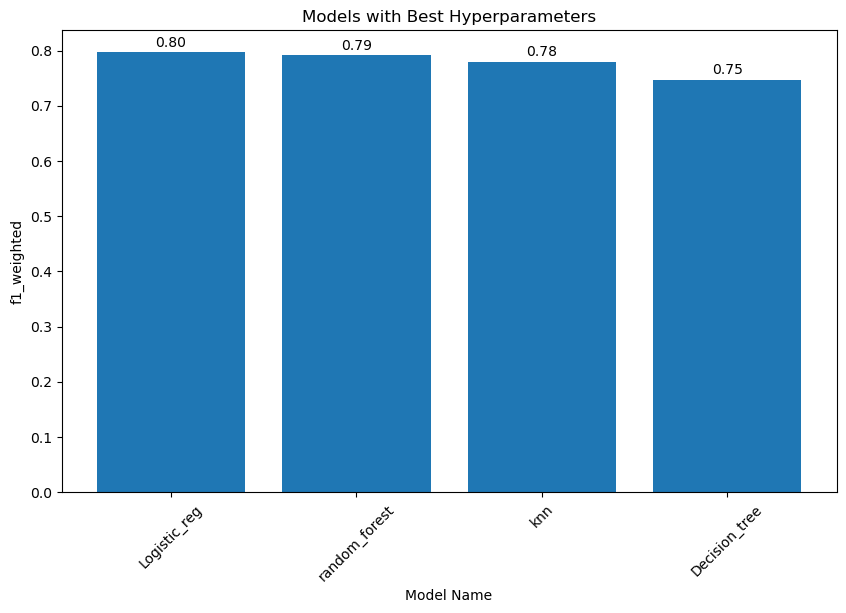

In [19]:
# Get models f1_weighted scores and names
model_names = [model_name for model_name in search_histories.keys()]
model_scores = [search_history['mean_test_f1_weighted'].max() for search_history in search_histories.values()]

# Create a DataFrame to for plot
df_models = pd.DataFrame({'model_name': model_names, 'f1_weighted': model_scores})
df_models = df_models.sort_values(by='f1_weighted', ascending=False)


# Create a bar chart
plt.figure(figsize=(10,6))
plt.bar(data=df_models, x='model_name', height='f1_weighted')

# Add text labels to the bars
for i, score in enumerate(df_models['f1_weighted']):
    plt.text(i, score+0.01, '{:1.2f}'.format(score), ha="center")

plt.xlabel('Model Name')
plt.ylabel('f1_weighted')
plt.title('Models with Best Hyperparameters')
plt.xticks(rotation=45)
plt.show()

In [ ]:
best_model_name = df_models['model_name'].iloc[0]
best_model = dict(best_models).get(best_model_name)
best_model

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('num_imputer',
                                                                   SimpleImputer(strategy='median')),
                                                                  ('num_scaler',
                                                                   StandardScaler())]),
                                                  Index(['seniorcitizen', 'tenure', 'monthlycharges', 'totalcharges'], dtype='object')),
                                                 ('cat',
                                                  Pipeline(steps=[('cat_imputer',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('cat-encoder',
                                                                   OneH...(handle_unknown='ignore'))]),
                                                  Index(['gender', 'partner', 'dependents', 'phoneservice', 'multiplelines',
       'internetservice', 'onlinesecurity', 'onlinebackup', 'deviceprotection',
       'techsupport', 'streamingtv', 'streamingmovies', 'contract',
       'paperlessbilling', 'paymentmethod'],
      dtype='object'))])),
                ('classifier',
                 LogisticRegression(C=1, max_iter=300, random_state=42))])

#### Evaluate the best model on the evaluation set

In [43]:
y_eval_pred = best_model.predict(X_eval)
print(f'Classification report of the best model- {best_model_name}\n\n{classification_report(y_true=y_eval_encoded, y_pred=y_eval_pred)}')

Classification report of the best model- Logistic_reg

              precision    recall  f1-score   support

           0       0.85      0.88      0.87       742
           1       0.63      0.58      0.61       267

    accuracy                           0.80      1009
   macro avg       0.74      0.73      0.74      1009
weighted avg       0.79      0.80      0.80      1009



#### Prepare the test dataset

In [20]:
test_df = pd.read_excel('Data/Telco-churn-last-2000.xlsx')

In [21]:
test_df.drop('customerID', axis=1, inplace =True)

In [22]:
test_df.columns = test_df.columns.str.lower()


In [23]:
# test_df['totalcharges'] = test_df['totalcharges'].
test_df['totalcharges'] = pd.to_numeric(test_df['totalcharges'], errors = 'coerce')

In [24]:
train_df.head()

,gender,seniorcitizen,partner,dependents,tenure,phoneservice,multiplelines,internetservice,onlinesecurity,onlinebackup,deviceprotection,techsupport,streamingtv,streamingmovies,contract,paperlessbilling,paymentmethod,monthlycharges,totalcharges,churn
0,Female,0,Yes,No,1,No,NaN,DSL,No,Yes,No,No,No,No,Month-to-month,Yes,Electronic check,29.850000,29.850000,No
1,Male,0,No,No,34,Yes,No,DSL,Yes,No,Yes,No,No,No,One year,No,Mailed check,56.950001,1889.500000,No
2,Male,0,No,No,2,Yes,No,DSL,Yes,Yes,No,No,No,No,Month-to-month,Yes,Mailed check,53.849998,108.150002,Yes
3,Male,0,No,No,45,No,NaN,DSL,Yes,No,Yes,Yes,No,No,One year,No,Bank transfer (automatic),42.299999,1840.750000,No
4,Female,0,No,No,2,Yes,No,Fiber optic,No,No,No,No,No,No,Month-to-month,Yes,Electronic check,70.699997,151.649994,Yes


#### Using the Test Data to test our model and predict churn of customers

In [27]:
predicted_churn = best_model.predict(test_df)
predicted_churn

array([1, 0, 0, ..., 1, 0, 0])

In [41]:
# Create an array of corresponding labels
labels = np.array(['No', 'Yes']) # Index 0 is No, 1 is Yes
test_df['predicted_churn'] = labels[predicted_churn]

In [42]:
test_df.head(2)

,gender,seniorcitizen,partner,dependents,tenure,phoneservice,multiplelines,internetservice,onlinesecurity,onlinebackup,deviceprotection,techsupport,streamingtv,streamingmovies,contract,paperlessbilling,paymentmethod,monthlycharges,totalcharges,predicted_churn
0,Male,0,No,No,12,Yes,Yes,Fiber optic,No,No,No,No,Yes,No,Month-to-month,Yes,Electronic check,84.45,1059.55,Yes
1,Male,0,No,No,9,Yes,No,No,No internet service,No internet service,No internet service,No internet service,No internet service,No internet service,Month-to-month,No,Mailed check,20.40,181.80,No
